<font color='RED'>
    
# Implementación del sistema de reconocimiento de imágenes con Pytorch y usando el conjunto de datos CIFAR-10

<font color='BLUE'>
    
# Bibliografia
-------[Nb de Pytorch.org](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/17a7c7cb80916fcdf921097825a0f562/cifar10_tutorial.ipynb#scrollTo=5-WzFSa-4b0l)-------
    
-------[Nb de medium.com](https://jovian.ai/sergioalves94/03-cifar10-feedforward/v/1?utm_source=embed)-------
                  

<font color='BLUE'>
    
# Instalación de Pytorch

In [20]:
!conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet

Solving environment: done

# All requested packages already installed.



<font color='BLUE'>
    
# Importación de las librerías necesarias

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from prettytable import PrettyTable
%matplotlib inline

<font color='BLUE'>
    
# Descarga e información general del Conjunto de datos

Files already downloaded and verified
+------------------+-----------------+-------------+
| # muestras train | # muestras test | # de clases |
+------------------+-----------------+-------------+
|      50000       |      10000      |      10     |
+------------------+-----------------+-------------+
+------------+
|   clases   |
+------------+
|  airplane  |
| automobile |
|    bird    |
|    cat     |
|    deer    |
|    dog     |
|    frog    |
|   horse    |
|    ship    |
|   truck    |
+------------+
+-------------------------+------------+--------------------+
|  Dimensiones del tensor | # de clase | nombre de la clase |
+-------------------------+------------+--------------------+
| torch.Size([3, 32, 32]) |     9      |       truck        |
+-------------------------+------------+--------------------+


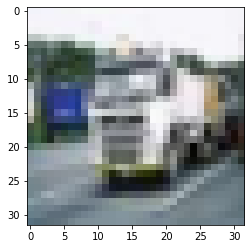

In [17]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor()) ##ToTensor convierte datos en el rango 0-255 a 0-1
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

#tablas con información
t = PrettyTable(['# muestras train','# muestras test','# de clases'])
t.add_row([len(dataset),len(test_dataset),len(dataset.classes)])
print(t)

t = PrettyTable(['clases'])
for i in dataset.classes:
    t.add_row([i])
print(t)

#muestra de una imagen del conjunto de entrenamiento
img, label = dataset[1000]
t = PrettyTable(['Dimensiones del tensor','# de clase','nombre de la clase'])
t.add_row([img.shape,label,dataset.classes[label]])
print(t)
plt.imshow(img.permute((1, 2, 0))) #se permutan las dimensiones del tensor de acuerdo a las entradas
                                   # requeridas por Matplotlib (dimensión RGB al último)


<font color='BLUE'>
    
# División del conjunto en Train y Validation

In [19]:
val_size = 5000 #10% del dataset
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

t = PrettyTable(['# muestras train','# muestras validation'])
t.add_row([len(train_ds),len(val_ds)])
print(t)

+------------------+-----------------------+
| # muestras train | # muestras validation |
+------------------+-----------------------+
|      45000       |          5000         |
+------------------+-----------------------+


<font color='BLUE'>
    
# Creación de lotes de datos

Dimensión de un lote: torch.Size([128, 3, 32, 32])


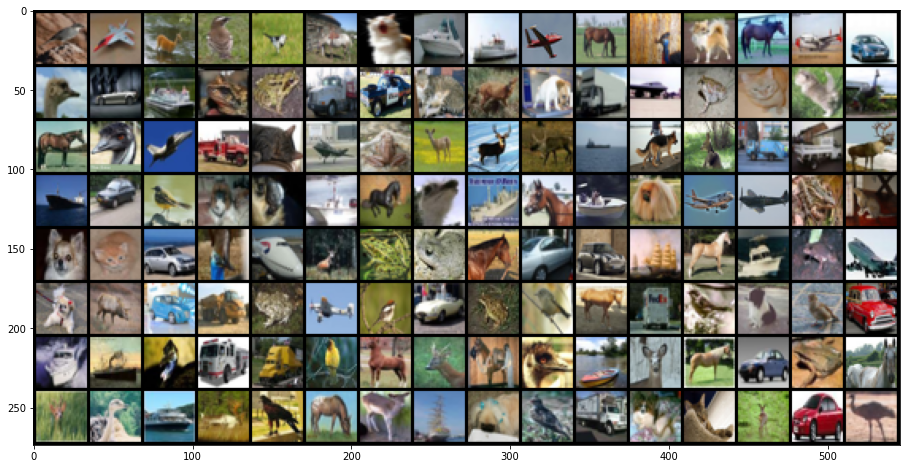

In [35]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

for images,_ in train_loader:
    print('Dimensión de un lote:', images.shape)
    plt.figure(figsize=(16,8))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

<font color='BLUE'>
    
# Construcción del modelo

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Predicciones
        loss = F.cross_entropy(out, labels) # Calculo de perdida
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Predicciones
        loss = F.cross_entropy(out, labels)   # Calculo de perdida
        acc = accuracy(out, labels)           # Calcula la precisión
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # promedio de pérdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # promedio de precisión
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase de entrenamiento
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # fase de validación
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    

<font color='BLUE'>
    
# Funciones para graficar pérdidas y precisiones

In [39]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

<font color='BLUE'>
    
# Disponibilidad y uso del GPU

In [43]:
if torch.cuda.is_available()==True:
    t = PrettyTable(['¿Hay GPU disponible?'])
    t.add_row(['Si'])
    print(t)
    def get_default_device():
        """Pick GPU if available, else CPU"""
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')


    device = get_default_device()

    def to_device(data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)

    class DeviceDataLoader():
        """Wrap a dataloader to move data to a device"""
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            """Yield a batch of data after moving it to device"""
            for b in self.dl: 
                yield to_device(b, self.device)

        def __len__(self):
            """Number of batches"""
            return len(self.dl)

    ##SE MUEVEN LOS DATA LOADERS AL GPU
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)
else:
    t = PrettyTable(['¿Hay GPU disponible?'])
    t.add_row(['No'])
    print(t)
    

+--------------------+
| Hay GPU disponible |
+--------------------+
|         No         |
+--------------------+
